In [1]:
import sys

print(sys.version)  # 3.6.8

3.6.8 (default, Dec 24 2018, 19:24:27) 
[GCC 5.4.0 20160609]


In [2]:
import tensorflow as tf

tf.enable_eager_execution()

In [3]:
tf.test.is_gpu_available()

True

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm

import numpy as np
import pandas as pd

import h5py

import pickle
import cv2
import os

import PIL
import time
import pathlib

from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE

from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, r2_score

from pandas.plotting import scatter_matrix

from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

from math import sqrt

from itertools import combinations, combinations_with_replacement

from cycler import cycler

In [6]:
BATCH_SIZE = 8


def _parse_predict_function(example_proto):
    # Create a description of the features.
    feature_description = {
        # [AREA_UNIT, AREA_ENTRANCE, AREA_LDK, AREA_BEDROOM, AREA_BALCONY, AREA_BATHROOM]
        "floorplan": tf.FixedLenFeature(
            [28, 28, 6], tf.float32, default_value=tf.zeros([28, 28, 6], tf.float32)
        ),
        "plan_id": tf.FixedLenFeature([], tf.string, default_value=""),
        "norm_year": tf.FixedLenFeature([], tf.float32, default_value=-1.0),
        "sido": tf.FixedLenFeature([], tf.int64, default_value=-1),
        "norm_area": tf.FixedLenFeature([], tf.float32, default_value=0.0),
        "is_area_85": tf.FixedLenFeature([], tf.int64, default_value=0),
        "is_core": tf.FixedLenFeature([], tf.int64, default_value=0),
        "num_rooms": tf.FixedLenFeature([], tf.int64, default_value=-1),
        "num_baths": tf.FixedLenFeature([], tf.int64, default_value=-1),
    }

    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.parse_single_example(example_proto, feature_description)

    return (
        parsed_example["floorplan"],
        parsed_example["plan_id"],
        parsed_example["norm_year"],
    )


def create_predict_dataset(filepaths):

    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepaths, compression_type="GZIP")

    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_predict_function, num_parallel_calls=8)

    # Set the batchsize
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [7]:
predict_dataset = create_predict_dataset(["/data/fp.tfrecord",])

In [8]:
ids, fps = [], []

iter = predict_dataset.make_one_shot_iterator()
for batch in iter:
    ids.extend(batch[1].numpy())
    fps.extend(batch[0].numpy())

ids = [id.decode() for id in ids]

len(ids), ids[0], len(fps), fps[0].shape

W0129 07:48:06.742623 139988061882112 deprecation.py:323] From <ipython-input-8-2ae9ed37f69b>:3: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


(50540, '23112_103F', 50540, (28, 28, 6))

In [9]:
fps_array = np.asarray(fps)
X = fps_array.reshape(50540, 4704)

In [10]:
X.shape

(50540, 4704)

In [11]:
from time import perf_counter

In [12]:
from sklearn.neighbors import NearestNeighbors

# n = 8000

t0_ball = perf_counter()

neigh = NearestNeighbors(algorithm="ball_tree", radius=5, n_jobs=-1)

# neigh.fit(X[:n])
neigh.fit(X)

dist = neigh.radius_neighbors_graph(mode="distance")

t1_ball = perf_counter()

# 1000: 1s, 4000: 14s, 16000: 244s, 50540: 2780s ~= 46m
print("ball: {:.2f}s,".format(t1_ball - t0_ball))

ball: 2454.97s,


In [13]:
# dist.indptr[dist.indices], dist.data
dist.data.shape

(16714,)

In [14]:
from sklearn.cluster import DBSCAN

t0 = perf_counter()

# min_samples=1 means every data point is a cluster
clust = DBSCAN(eps=5, min_samples=1, metric="precomputed", n_jobs=-1)

t1 = perf_counter()

clust.fit(dist)

t2 = perf_counter()

print("{:.2f}s, {:.2f}s".format(t1 - t0, t2 - t1))

0.00s, 1.09s


In [15]:
np.count_nonzero(clust.labels_ >= 0)

50540

In [16]:
# n of clusters by size
labels, counts = np.unique(clust.labels_, return_counts=True)
np.unique(counts, return_counts=True)

### 50540 - 40049 = 10491 개 평면에 대해 유사한 평면끼리 묶어서 데이터셋 분리

### min_samples=2 == single linkage: 최대 28개 평면이 하나의 군집으로 묶임
# (array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 16, 28]),
#  array([40049,  3551,   581,   194,    71,    35,    10,     8,     5,
#             2,     2,     2,     1,     1,     1]))

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 16, 28]),
 array([40049,  3551,   581,   194,    71,    35,    10,     8,     5,
            2,     2,     2,     1,     1,     1]))

In [17]:
labels, counts

(array([    0,     1,     2, ..., 44510, 44511, 44512]),
 array([2, 1, 1, ..., 1, 1, 1]))

In [18]:
np.nonzero(counts == 28)

(array([731]),)

In [19]:
labels[731]

731

In [20]:
np.nonzero(clust.labels_ == labels[np.nonzero(counts == 28)])

(array([  734,  3461,  4161,  7627,  9037, 11039, 11969, 14407, 15281,
        15680, 17068, 18162, 21489, 21973, 22035, 24143, 24314, 27673,
        33408, 35454, 43761, 44308, 45264, 45874, 48215, 49568, 49573,
        49917]),)

In [21]:
# list of fps
(c28,) = np.nonzero(clust.labels_ == labels[np.nonzero(counts == 28)])
print(c28)
ids_c28 = [ids[i] for i in c28]
print(ids_c28)

apt_c28 = [int(id.split("_")[0]) for id in ids_c28]
print(np.unique(apt_c28, return_counts=True))

sorted_c28 = [x for y, x in sorted(zip(apt_c28, c28))]
print(sorted_c28)

[  734  3461  4161  7627  9037 11039 11969 14407 15281 15680 17068 18162
 21489 21973 22035 24143 24314 27673 33408 35454 43761 44308 45264 45874
 48215 49568 49573 49917]
['23946_103', '109480_105', '109432_105', '23957_102', '101023_114', '23962_101', '101031_112', '23940_107', '22417_106', '108260_113', '18952_107A', '101184_113', '23939_107', '23948_100', '102294_106', '24187_105', '17573_100', '106040_115', '23944_102', '109388_112', '23945_102', '23953_101', '23964_101', '23943_105', '13463_106', '108601_106', '23959_100', '23947_102']
(array([ 13463,  17573,  18952,  22417,  23939,  23940,  23943,  23944,
        23945,  23946,  23947,  23948,  23953,  23957,  23959,  23962,
        23964,  24187, 101023, 101031, 101184, 102294, 106040, 108260,
       108601, 109388, 109432, 109480]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1]))
[48215, 24314, 17068, 15281, 21489, 14407, 45874, 33408, 43761, 734, 49917, 21973, 44308, 7627, 4

In [22]:
df_apt = pd.read_csv("/data/apartments.csv", index_col="ID")
df_apt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29663 entries, 8928 to 115454
Data columns (total 2 columns):
name      29663 non-null object
parent    29663 non-null int64
dtypes: int64(1), object(1)
memory usage: 695.2+ KB


In [23]:
df_apt.loc[apt_c28].sort_index()
# 부영!
# 순천 율산에코지오 (부영12차)

,name,parent
ID,,
13463,가좌마을부영그린타운1차,4311112100
17573,갑오마을10단지부영e그린타운,4825012800
18952,부영,4211039000
22417,장자마을3단지부영,4311112000
23939,화정마을2단지부영,4825010700
23940,화정마을5단지부영,4825010700
23943,부영1차,4812916200
23944,월산마을2단지부영,4825012500
23945,갑오마을5단지부영,4825012900


In [24]:
channel_to_rgba = np.concatenate(
    (
        [[0.0, 0.0, 0.0, 1.0]],  # unit mask to alpha
        (
            -1.0  # make colors subtractive
            + np.array(
                [
                    [0.0, 0.33, 0.0, 1.0],  # entrance to green L30
                    [1.0, 0.25, 0.0, 1.0],  # LDK to red L57
                    [0.0, 0.26, 1.0, 1.0],  # bedroom to blue L40
                    [0.83, 0.87, 0.0, 1.0],  # balcony to yellow L85
                    [0.0, 0.81, 0.76, 1.0],  # bathroom to cyan L75
                ]
            )
        ),
    )
)

print(channel_to_rgba)
# [[ 0.    0.    0.    1.  ]
#  [-1.   -0.67 -1.    0.  ]
#  [ 0.   -0.75 -1.    0.  ]
#  [-1.   -0.74  0.    0.  ]
#  [-0.17 -0.13 -1.    0.  ]
#  [-1.   -0.19 -0.24  0.  ]]

# put it on transparent white
fps_rgba = np.clip(
    np.array([1.0, 1.0, 1.0, 0.0]) + (np.array(fps) @ channel_to_rgba), 0, 1
)

[[ 0.    0.    0.    1.  ]
 [-1.   -0.67 -1.    0.  ]
 [ 0.   -0.75 -1.    0.  ]
 [-1.   -0.74  0.    0.  ]
 [-0.17 -0.13 -1.    0.  ]
 [-1.   -0.19 -0.24  0.  ]]


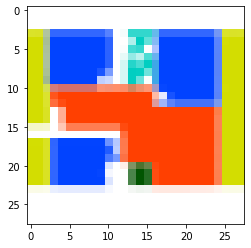

In [25]:
fig = plt.figure()
ax = plt.imshow(fps_rgba[ids.index("9765_107A")])

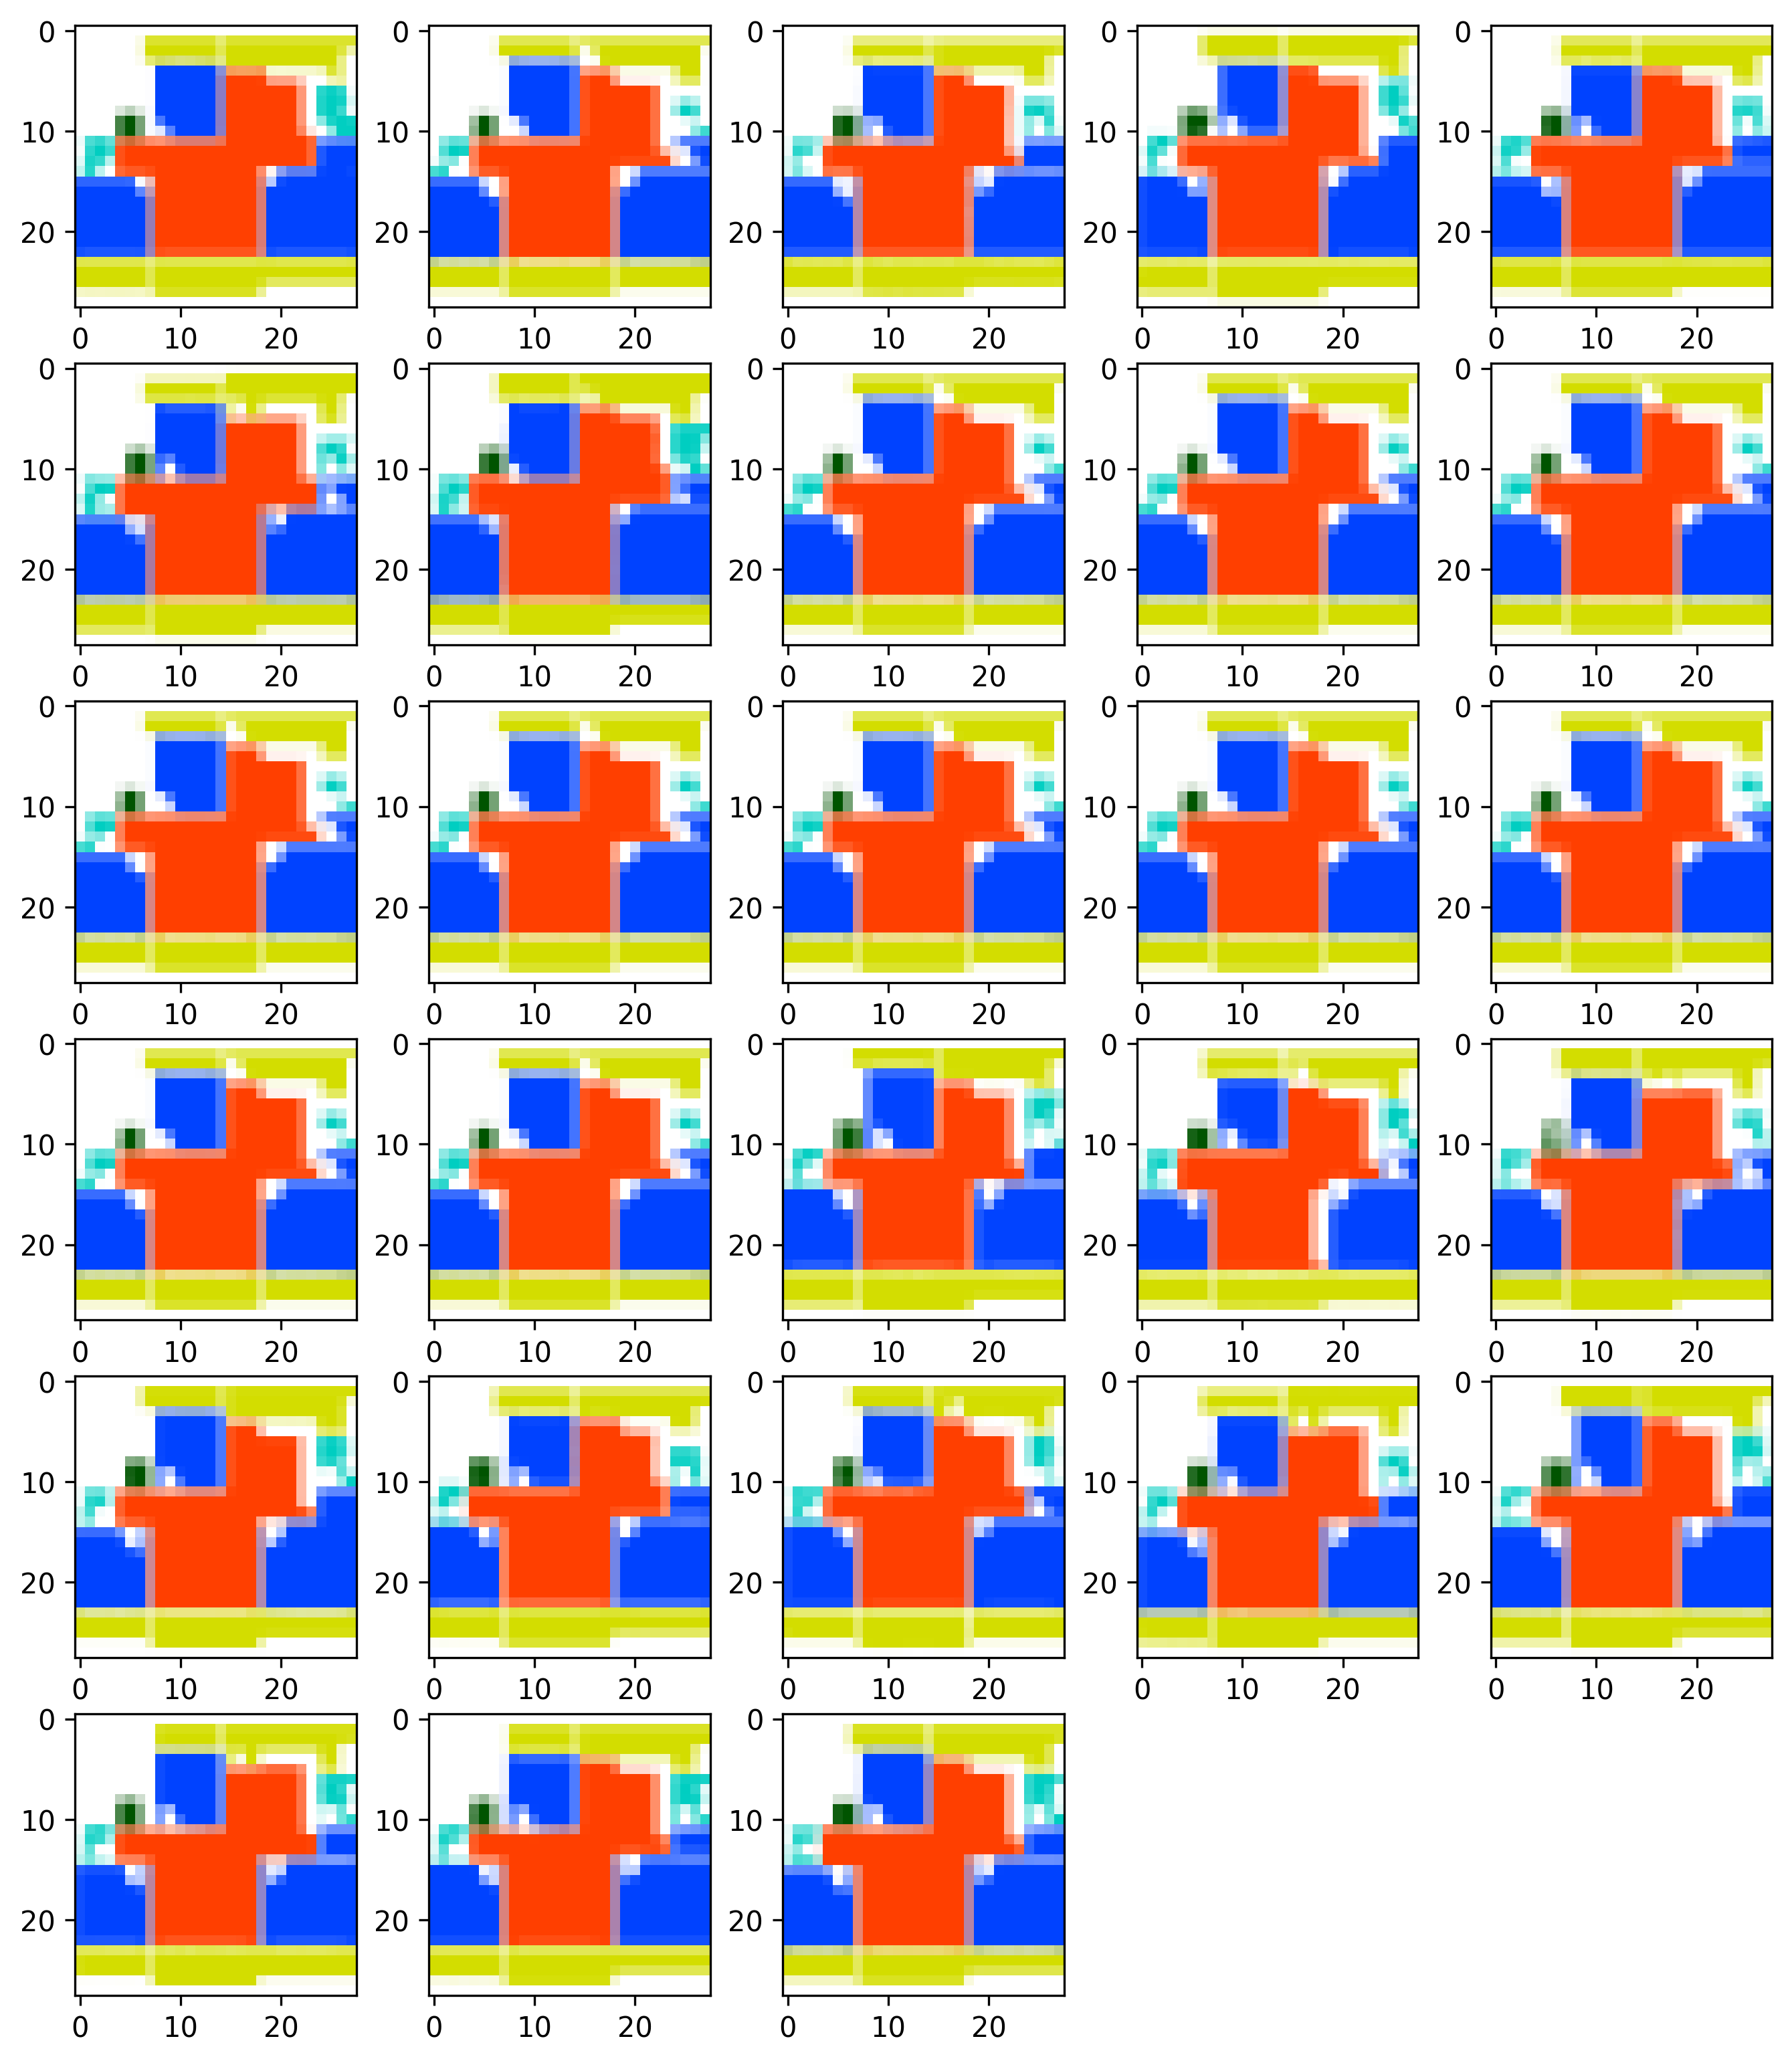

In [26]:
fig, axes = plt.subplots(6, 5, figsize=(11, 13), dpi=300)

for i, idx in enumerate(sorted_c28):
    axes[divmod(i, 5)].imshow(fps_rgba[idx])

for i in range(len(sorted_c28), 30):
    fig.delaxes(axes[divmod(i, 5)])

plt.show()
fig.savefig("fp_similar.pdf", bbox_inches="tight", pad_inches=0)
fig.savefig("fp_similar.png", bbox_inches="tight", pad_inches=0)

In [33]:
# TODO: save cluster
df = pd.DataFrame({"ID": ids, "similar_cluster": clust.labels_})

# https://stackoverflow.com/questions/50004641/select-sample-random-groups-after-groupby-in-pandas
g = df.groupby(["similar_cluster"])

a = np.arange(g.ngroups)
np.random.seed(1106)
np.random.shuffle(a)

df["test"] = g.ngroup().isin(a[:9000]).astype(int)
df["train"] = 1-df["test"]

print(df.test.value_counts())
print(df.train.value_counts())

0    40355
1    10185
Name: test, dtype: int64
1    40355
0    10185
Name: train, dtype: int64


In [34]:
df.to_csv('/data/fp_dataset.csv')